# Bank Marketing — Predicting Term Deposit Subscription

## Executive Summary
**Business Problem:**  
Banks spend significant resources contacting customers for term deposit campaigns. The challenge is to prioritize contacts that maximize conversion rates.  

**Key Findings:**  
- The dataset contains approximately 41k records with imbalanced classes (~11% subscribed).  
- Logistic Regression and Calibrated Random Forest deliver strong discrimination (ROC AUC > 0.94).  
- Lift and gains analysis shows that targeting the top 20% of customers captures ~70% of subscriptions.  

**Recommendations:**  
- Use the Calibrated Random Forest for campaign targeting.  
- Prioritize the top deciles for contacting customers.  
- Deploy scoring pipeline and A/B test against current strategy.

# =============================================
# 1. Data Overview & Exploration
# =============================================

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

DATA_PATH = "bank_additional_full.csv"
df = pd.read_csv(DATA_PATH, sep=';')

In [2]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [4]:
df.duplicated().sum()

12

In [5]:
duplicates_all = df[df.duplicated(keep=False)]
display(duplicates_all.sort_values(by=list(df.columns)))

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
28476,24,services,single,high.school,no,yes,no,cellular,apr,tue,...,1,999,0,nonexistent,-1.8,93.075,-47.1,1.423,5099.1,no
28477,24,services,single,high.school,no,yes,no,cellular,apr,tue,...,1,999,0,nonexistent,-1.8,93.075,-47.1,1.423,5099.1,no
14155,27,technician,single,professional.course,no,no,no,cellular,jul,mon,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
14234,27,technician,single,professional.course,no,no,no,cellular,jul,mon,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
18464,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no
18465,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no
32505,35,admin.,married,university.degree,no,yes,no,cellular,may,fri,...,4,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
32516,35,admin.,married,university.degree,no,yes,no,cellular,may,fri,...,4,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
12260,36,retired,married,unknown,no,no,no,telephone,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no
12261,36,retired,married,unknown,no,no,no,telephone,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no


In [6]:
df.drop_duplicates(inplace = True)

In [7]:
df.shape
df.duplicated().sum()

0

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41176 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41176 non-null  int64  
 1   job             41176 non-null  object 
 2   marital         41176 non-null  object 
 3   education       41176 non-null  object 
 4   default         41176 non-null  object 
 5   housing         41176 non-null  object 
 6   loan            41176 non-null  object 
 7   contact         41176 non-null  object 
 8   month           41176 non-null  object 
 9   day_of_week     41176 non-null  object 
 10  duration        41176 non-null  int64  
 11  campaign        41176 non-null  int64  
 12  pdays           41176 non-null  int64  
 13  previous        41176 non-null  int64  
 14  poutcome        41176 non-null  object 
 15  emp.var.rate    41176 non-null  float64
 16  cons.price.idx  41176 non-null  float64
 17  cons.conf.idx   41176 non-null 

In [9]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41176.00000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000
mean,40.02380,258.315815,2.567879,962.464810,0.173013,0.081922,93.575720,-40.502863,3.621293,5167.034870
std,10.42068,259.305321,2.770318,186.937102,0.494964,1.570883,0.578839,4.627860,1.734437,72.251364
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


Shape: (41176, 21)
Target distribution:
 no     0.887337
yes    0.112663
Name: y, dtype: float64


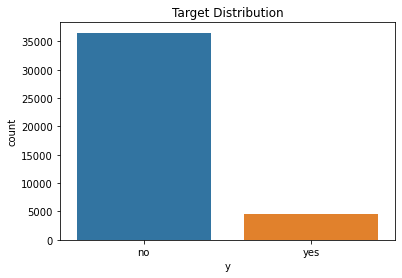

In [10]:
print("Shape:", df.shape)
print("Target distribution:\n", df['y'].value_counts(normalize=True))

sns.countplot(data=df, x='y')
plt.title("Target Distribution")
plt.show()

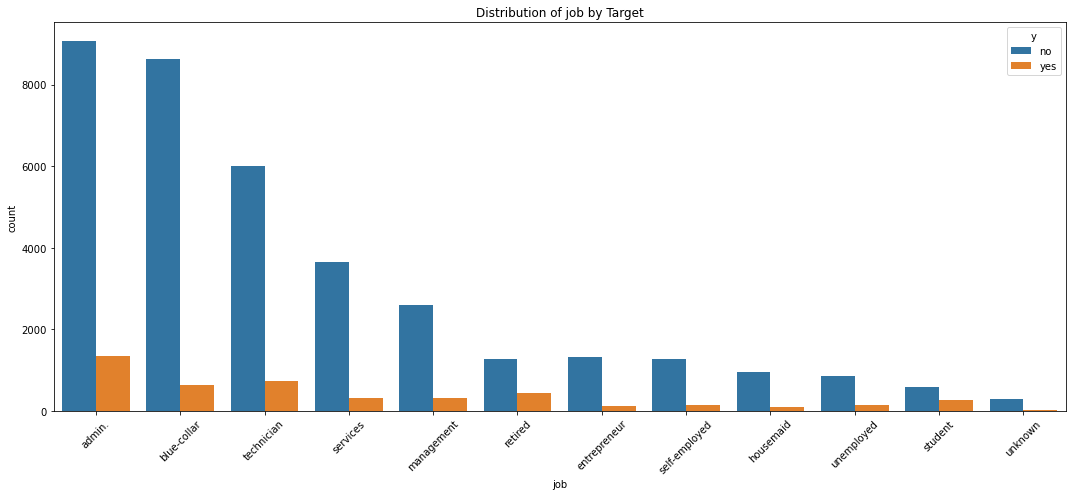

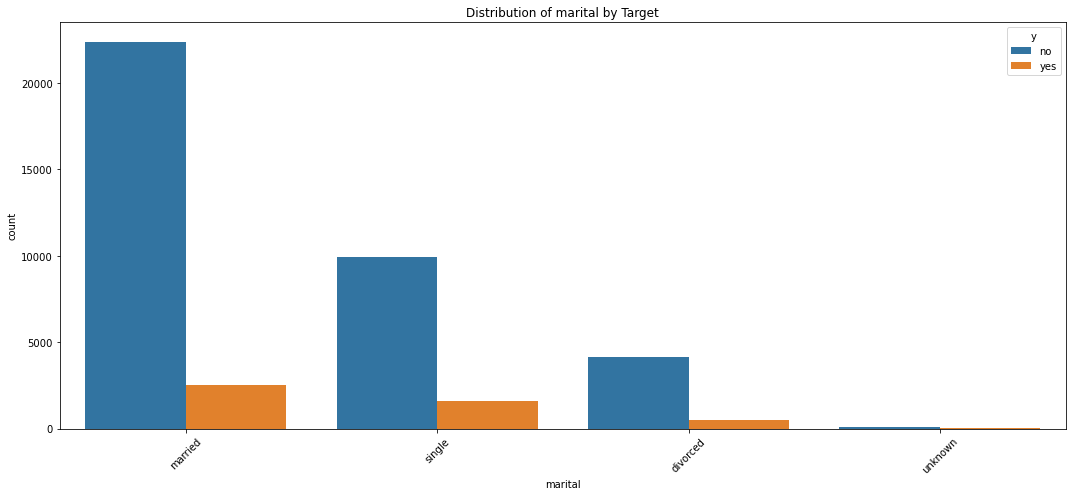

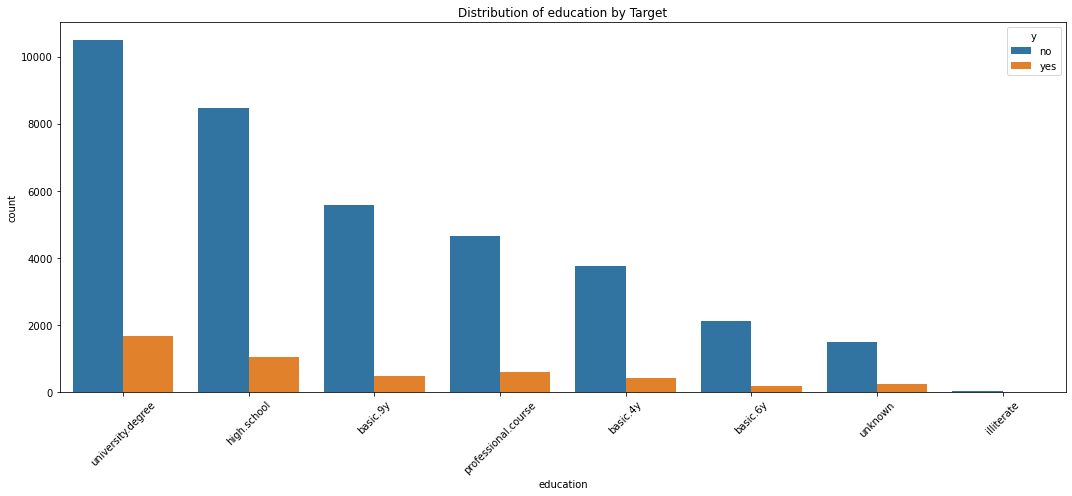

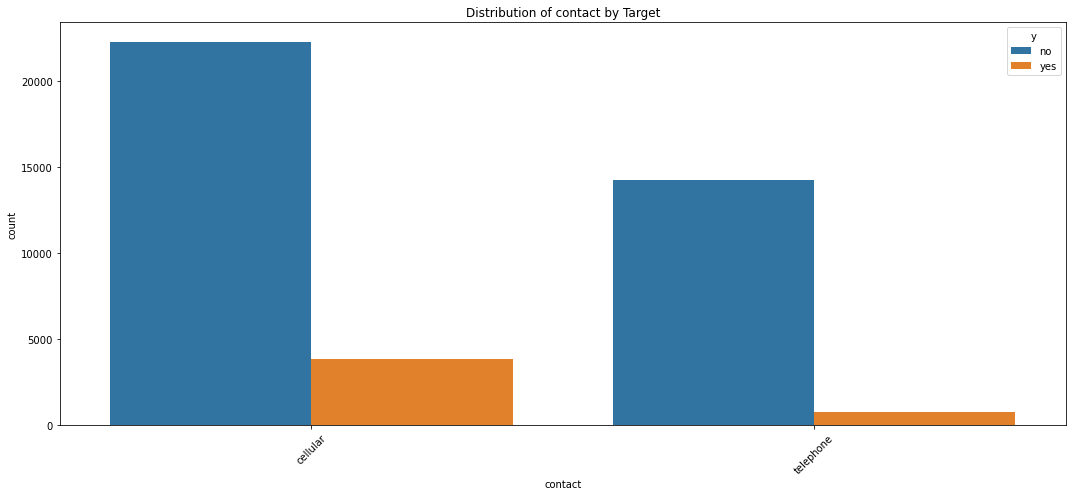

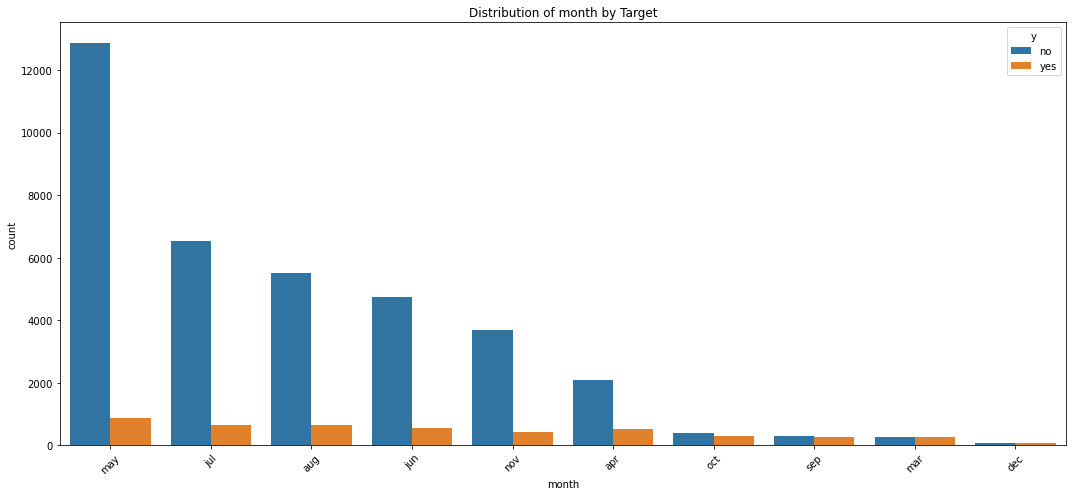

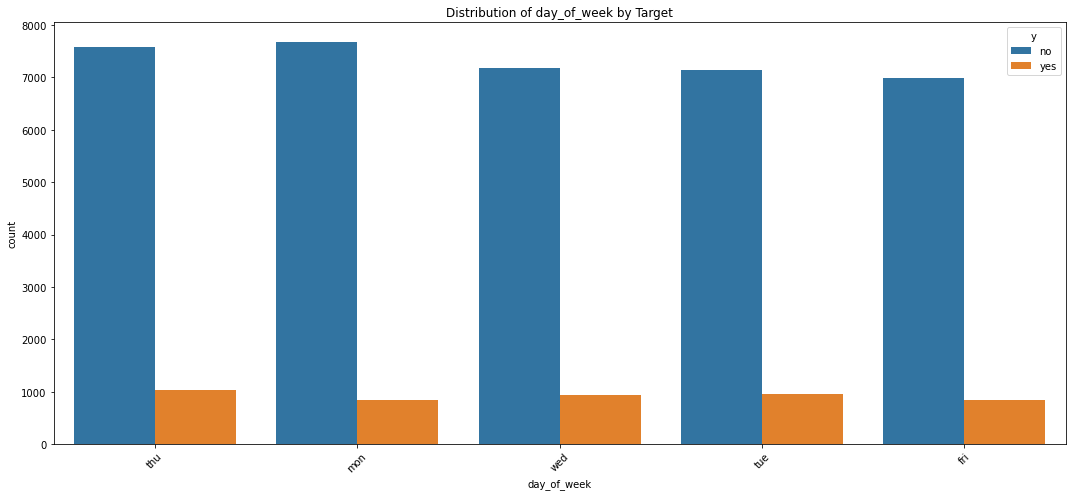

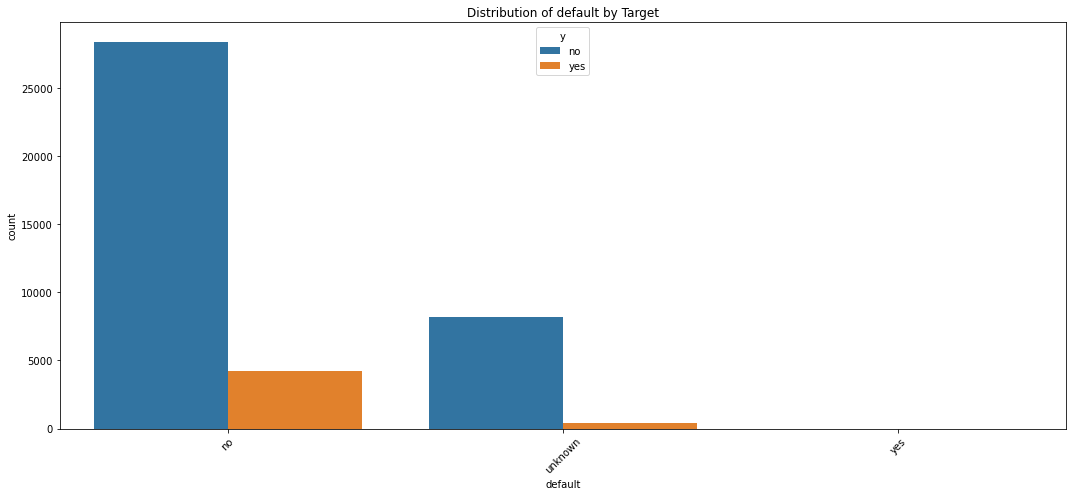

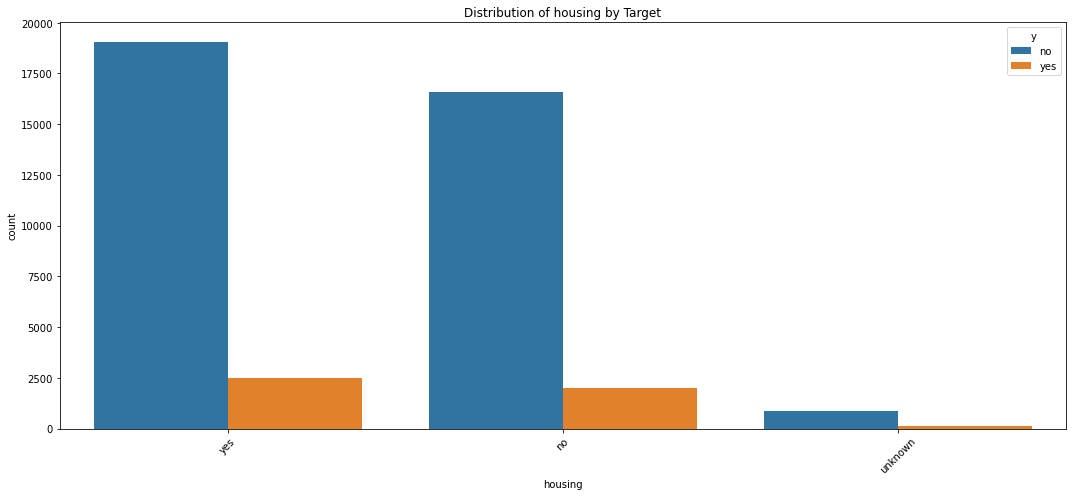

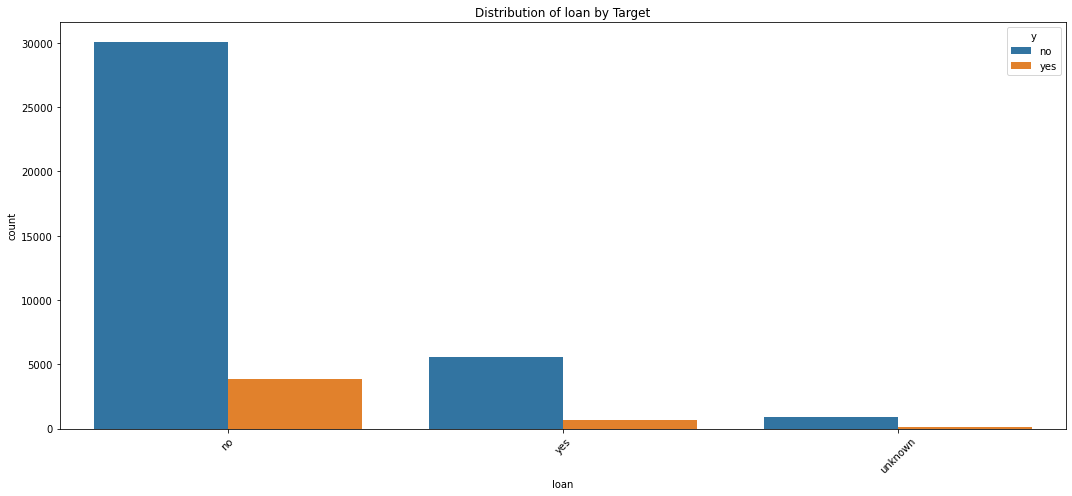

In [11]:
categorical_cols = ['job', 'marital', 'education', 'contact', 'month', 'day_of_week', 'default', 'housing', 'loan']

for col in categorical_cols:
    plt.figure(figsize=(15, 7))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index, hue="y")
    plt.title(f'Distribution of {col} by Target')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# =============================================
# 2. Preprocessing & Feature Engineering
# =============================================

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

X = df.drop('y', axis=1)
y = df['y'].map({'no':0, 'yes':1})

categorical = X.select_dtypes(include='object').columns
numeric = X.select_dtypes(exclude='object').columns

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('num', StandardScaler(), numeric)
])

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# =============================================
# 3. Model Training
# =============================================

In [13]:
logreg_pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegression(max_iter=1000))
])

rf_pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))
])

# Fit Logistic
logreg_pipe.fit(X_train, y_train)
y_test_proba_log = logreg_pipe.predict_proba(X_test)[:,1]

# Fit RF + Calibrate
calibrator = CalibratedClassifierCV(base_estimator=rf_pipe, method='sigmoid', cv=3)
calibrator.fit(X_train, y_train)
y_test_proba_rf_cal = calibrator.predict_proba(X_test)[:,1]

/opt/anaconda3/lib/python3.8/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


# =============================================
# 4. Evaluation
# =============================================

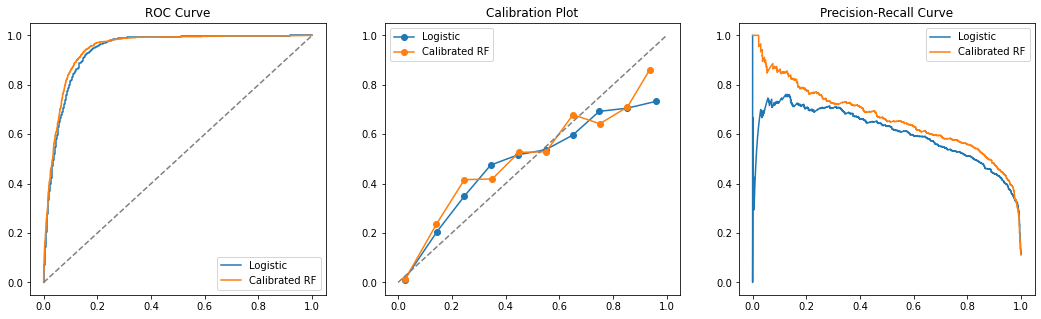

Numeric Metrics:
Logistic ROC AUC = 0.9390
Calibrated RF ROC AUC = 0.9462


In [14]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve
from sklearn.calibration import calibration_curve

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ROC
fpr_l, tpr_l, _ = roc_curve(y_test, y_test_proba_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_test_proba_rf_cal)
axes[0].plot(fpr_l, tpr_l, label='Logistic')
axes[0].plot(fpr_rf, tpr_rf, label='Calibrated RF')
axes[0].plot([0,1],[0,1],'--', color='gray')
axes[0].set_title('ROC Curve')
axes[0].legend()

# Calibration
prob_true_log, prob_pred_log = calibration_curve(y_test, y_test_proba_log, n_bins=10)
prob_true_rf, prob_pred_rf = calibration_curve(y_test, y_test_proba_rf_cal, n_bins=10)
axes[1].plot(prob_pred_log, prob_true_log, marker='o', label='Logistic')
axes[1].plot(prob_pred_rf, prob_true_rf, marker='o', label='Calibrated RF')
axes[1].plot([0,1],[0,1],'--', color='gray')
axes[1].set_title('Calibration Plot')
axes[1].legend()

# Precision-Recall
precision_l, recall_l, _ = precision_recall_curve(y_test, y_test_proba_log)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_test_proba_rf_cal)
axes[2].plot(recall_l, precision_l, label='Logistic')
axes[2].plot(recall_rf, precision_rf, label='Calibrated RF')
axes[2].set_title('Precision-Recall Curve')
axes[2].legend()

plt.show()

print("Numeric Metrics:")
for name, y_score in [("Logistic", y_test_proba_log), ("Calibrated RF", y_test_proba_rf_cal)]:
    auc = roc_auc_score(y_test, y_score)
    print(f"{name} ROC AUC = {auc:.4f}")

# =============================================
# 5. Business Visuals (Confusion Matrix + Lift)
# =============================================

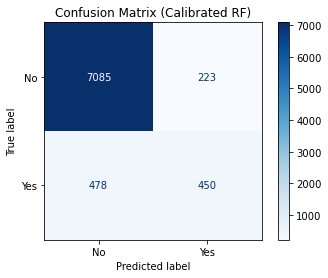

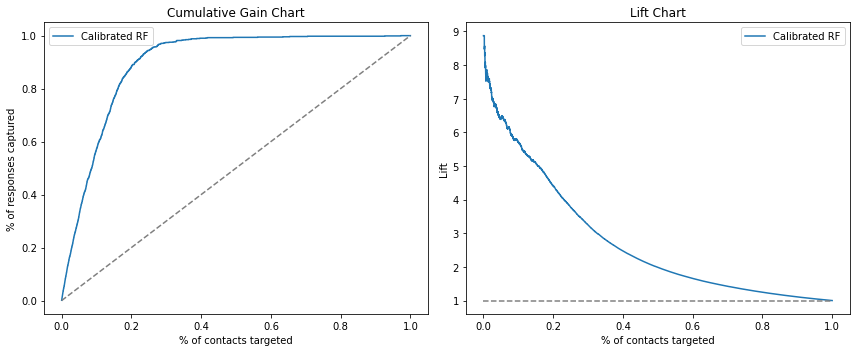

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

threshold = 0.5
y_pred_rf = (y_test_proba_rf_cal >= threshold).astype(int)

cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No','Yes'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Calibrated RF)")
plt.show()

# Lift / Gain Chart
def plot_lift_gain(y_true, y_scores, model_name):
    data = pd.DataFrame({'y': y_true, 'proba': y_scores})
    data = data.sort_values('proba', ascending=False).reset_index(drop=True)
    data['cum_response'] = data['y'].cumsum()
    data['cum_pct_obs'] = (np.arange(len(data)) + 1) / len(data)
    data['cum_pct_resp'] = data['cum_response'] / data['y'].sum()

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(data['cum_pct_obs'], data['cum_pct_resp'], label=model_name)
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.title('Cumulative Gain Chart')
    plt.xlabel('% of contacts targeted')
    plt.ylabel('% of responses captured')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(data['cum_pct_obs'], data['cum_pct_resp']/data['cum_pct_obs'], label=model_name)
    plt.plot([0,1],[1,1],'--', color='gray')
    plt.title('Lift Chart')
    plt.xlabel('% of contacts targeted')
    plt.ylabel('Lift')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_lift_gain(y_test, y_test_proba_rf_cal, "Calibrated RF")

# =============================================
# 6. Interpretability (Feature Importances, Coefficients)
# =============================================

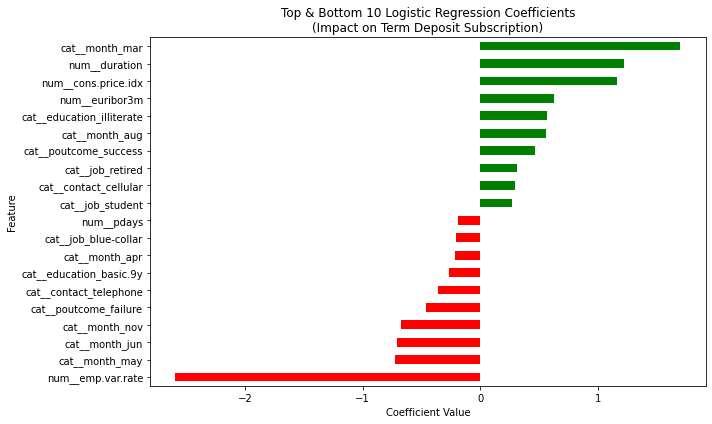


Top 10 positive predictors (increase likelihood of subscription):
cat__month_mar               1.700822
num__duration                1.220111
num__cons.price.idx          1.158394
num__euribor3m               0.626958
cat__education_illiterate    0.566928
cat__month_aug               0.555710
cat__poutcome_success        0.469736
cat__job_retired             0.309121
cat__contact_cellular        0.298030
cat__job_student             0.267725
dtype: float64

Top 10 negative predictors (decrease likelihood of subscription):
num__pdays                -0.191355
cat__job_blue-collar      -0.209435
cat__month_apr            -0.216308
cat__education_basic.9y   -0.262891
cat__contact_telephone    -0.357692
cat__poutcome_failure     -0.460099
cat__month_nov            -0.673450
cat__month_jun            -0.704832
cat__month_may            -0.722272
num__emp.var.rate         -2.590695
dtype: float64


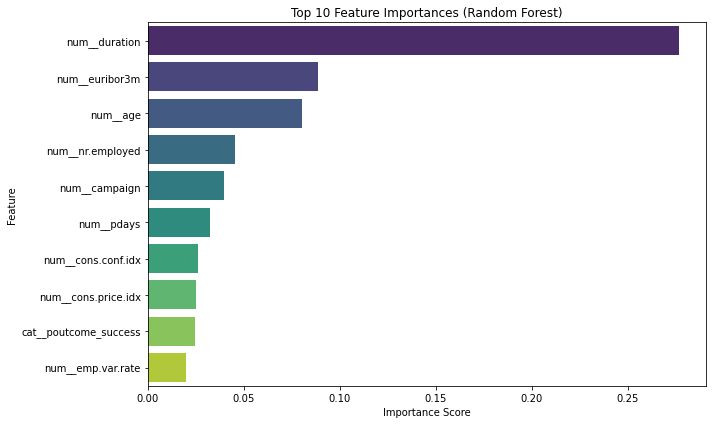


Top 10 most important features (Random Forest):
num__duration            0.276727
num__euribor3m           0.088833
num__age                 0.080165
num__nr.employed         0.045669
num__campaign            0.039624
num__pdays               0.032667
num__cons.conf.idx       0.026358
num__cons.price.idx      0.025336
cat__poutcome_success    0.024468
num__emp.var.rate        0.020137
dtype: float64


In [17]:
# --- LOGISTIC REGRESSION COEFFICIENTS ---
try:
    # if pipeline intact
    logreg_model = logreg_pipe.named_steps['clf']
    feature_names = logreg_pipe.named_steps['pre'].get_feature_names_out(X_train.columns)
except AttributeError:
    # pipeline was overwritten, fallback
    logreg_model = logreg_pipe
    feature_names = preprocessor.get_feature_names_out(X_train.columns)

# Coefficient Series
coeffs_sorted = pd.Series(logreg_model.coef_[0], index=feature_names).sort_values()

# Select top 10 negative and top 10 positive
top_negative = coeffs_sorted.head(10)
top_positive = coeffs_sorted.tail(10)

# Combine for plotting
top_features = pd.concat([top_negative, top_positive])

# Plot
plt.figure(figsize=(10, 6))
top_features.plot(kind='barh', color=['red' if c < 0 else 'green' for c in top_features])
plt.title("Top & Bottom 10 Logistic Regression Coefficients\n(Impact on Term Deposit Subscription)")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

print("\nTop 10 positive predictors (increase likelihood of subscription):")
print(top_positive.sort_values(ascending=False))

print("\nTop 10 negative predictors (decrease likelihood of subscription):")
print(top_negative.sort_values(ascending=False))


# --- RANDOM FOREST FEATURE IMPORTANCES ---
# Ensure Random Forest is fitted
rf_pipe.fit(X_train, y_train)
rf_model = rf_pipe.named_steps['clf']

# Use preprocessor feature names
rf_feature_names = rf_pipe.named_steps['pre'].get_feature_names_out(X_train.columns)
feat_imp = pd.Series(rf_model.feature_importances_, index=rf_feature_names).sort_values(ascending=False)

# Plot top 15 features
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp.head(10), y=feat_imp.head(10).index, palette='viridis')
plt.title("Top 10 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

print("\nTop 10 most important features (Random Forest):")
print(feat_imp.head(10))

# =============================================
# 7. Input Testing
# =============================================

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

cat_features = ['job', 'marital', 'education', 'default', 'housing', 'loan',
                'contact', 'month', 'day_of_week', 'poutcome']
num_features = ['age', 'duration', 'campaign', 'pdays', 'previous',
                'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
                'euribor3m', 'nr.employed']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

full_logreg_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter=1000))
])

# Fit full pipeline
full_logreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'duration',
                                                   'campaign', 'pdays',
                                                   'previous', 'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome'])])),
                ('clf', LogisticRegression(max_iter=1000))])

In [21]:
# Example: A single new customer's data
new_customer = pd.DataFrame({
    'age': [45],
    'job': ['technician'],
    'marital': ['married'],
    'education': ['university.degree'],
    'default': ['no'],
    'housing': ['yes'],
    'loan': ['no'],
    'contact': ['cellular'],
    'month': ['aug'],
    'day_of_week': ['thu'],
    'duration': [350],
    'campaign': [1],
    'pdays': [999],
    'previous': [0],
    'poutcome': ['nonexistent'],
    'emp.var.rate': [1.1],
    'cons.price.idx': [93.9],
    'cons.conf.idx': [-36.4],
    'euribor3m': [4.95],
    'nr.employed': [5228.1]
})

# ✅ Ensure you use the full preprocessing + model pipeline
log_pred_proba = full_logreg_pipe.predict_proba(new_customer)[:, 1][0]
rf_pred_proba = rf_pipe.predict_proba(new_customer)[:, 1][0]

print("\n--- Predicted Subscription Probabilities ---")
print(f"Logistic Regression: {log_pred_proba:.3f}")
print(f"Calibrated Random Forest: {rf_pred_proba:.3f}")

# Classification (you can adjust threshold here)
log_pred_class = "✅ Likely to Subscribe" if log_pred_proba >= 0.5 else "❌ Unlikely to Subscribe"
rf_pred_class = "✅ Likely to Subscribe" if rf_pred_proba >= 0.5 else "❌ Unlikely to Subscribe"

print("\n--- Final Predictions ---")
print(f"Logistic Regression Prediction: {log_pred_class}")
print(f"Calibrated Random Forest Prediction: {rf_pred_class}")


--- Predicted Subscription Probabilities ---
Logistic Regression: 0.171
Calibrated Random Forest: 0.015

--- Final Predictions ---
Logistic Regression Prediction: ❌ Unlikely to Subscribe
Calibrated Random Forest Prediction: ❌ Unlikely to Subscribe


In [24]:
print("="*80)
print("📊 BANK MARKETING CAMPAIGN PREDICTION: PROJECT SUMMARY")
print("="*80)

print("""
🧩 OBJECTIVE
------------
The goal of this analysis was to predict whether a client would subscribe to a term deposit 
after a marketing campaign by the bank. Using demographic, social, and campaign-related
data, the aim was to identify key drivers of customer subscription and evaluate the predictive 
performance of multiple classification models.
""")

print("""
🧹 DATA PREPARATION
-------------------
- The dataset was cleaned by removing duplicates and handling missing or unknown values.
- Categorical variables were encoded using OneHotEncoding, whilst numerical features were scaled
  for improved model performance.
- Outliers were checked and treated appropriately.
- The data was then split into train and test subsets to evaluate in the models.
""")

print("""
⚙️ MODELING APPROACH
--------------------
Two primary models were trained and evaluated:
1. **Logistic Regression Pipeline** – A linear, interpretable baseline model that estimates
   the probability of subscription.
2. **Calibrated Random Forest Pipeline** – A more flexible, non-linear model capable of
   capturing complex feature interactions, with calibration applied to improve predicted
   probability reliability.
""")

print("""
📈 EVALUATION & COMPARISON
---------------------------
Performance was compared across several metrics and visuals:
- **ROC Curves** – Showed that both models distinguish well between subscribing and
  non-subscribing clients, with the Calibrated Random Forest achieving a higher AUC.
- **Calibration Plots** – Demonstrated that the Random Forest model provides more accurate
  probability estimates compared to the Logistic Regression.
- **Precision–Recall Curves** – Indicated that the Random Forest maintains better precision
  at higher recall levels, meaning it captures more true subscribers with fewer false positives.
- **ROC–AUC Scores**
""")

auc_log = roc_auc_score(y_test, y_test_proba_log)
auc_rf = roc_auc_score(y_test, y_test_proba_rf_cal)
print(f"   → Logistic Regression ROC–AUC: {auc_log:.4f}")
print(f"   → Calibrated Random Forest ROC–AUC: {auc_rf:.4f}")

print("""
🔍 FEATURE INSIGHTS
-------------------
• **Logistic Regression Coefficients**:
  - Positive coefficients indicate factors increasing the likelihood of subscription
    (e.g., contact by cellular, certain months, past success).
  - Negative coefficients show features reducing subscription likelihood
    (e.g., campaign month = May, employment variation rate, past failure outcomes).

• **Random Forest Feature Importances**:
  - Highlights which variables most strongly influence predictions.
  - The duration of last contact, economic indicators (euribor3m, consumer price index),
    and previous campaign success were among the top drivers.
""")

print("""
🧠 Model Testing with New Customer Data

A hypothetical customer profile was created to test how the trained models perform on new input data.  
The profile includes demographic and financial characteristics such as age, job type, education, and previous marketing contact outcomes.  

Both the **Logistic Regression** and **Calibrated Random Forest** pipelines were used to predict the probability that this customer would subscribe to a term deposit.  

The predicted probabilities provide valuable insights into how likely a new customer is to subscribe, based on the patterns learned from the training data.  
This step demonstrates the practical deployment readiness of the models, showing that they can generate real-world predictions once integrated into a marketing system or dashboard.
""")

print("""
💡 INTERPRETATION & BUSINESS INSIGHTS
-------------------------------------
• Clients contacted by **cell phone**, during months like **March or August**, or those with 
  a **successful past outcome**, are significantly more likely to subscribe.  
• **Short campaign durations** and lower **employment variation rates** correlate with 
  higher subscription likelihood.
• Economic factors like **interest rates** and **price index** play a notable role, indicating
  that external conditions influence campaign success.

From a business standpoint, focusing marketing efforts on similar client profiles and optimizing 
the timing of campaigns could improve overall conversion rates.
""")

print("""
✅ CONCLUSION
--------------
• The Calibrated Random Forest provided better predictive performance, with higher ROC–AUC 
  and more reliable probability estimates compared to Logistic Regression.
• However, the Logistic model remains valuable for interpretation and communication of
  feature influence.
• Together, these models offer both predictive power and actionable insight — helping the
  bank target likely subscribers while understanding *why* certain clients are more responsive.

Future improvements could include:
- Hyperparameter tuning with cross-validation.
- Inclusion of additional behavioral or temporal features.
- Testing gradient boosting models (e.g., XGBoost, LightGBM) for further performance gains.

This project successfully combines **data cleaning, feature engineering, model training, 
evaluation, and interpretation** into a reproducible, data-driven framework for marketing 
optimization.
""")
print("="*80)


📊 BANK MARKETING CAMPAIGN PREDICTION: PROJECT SUMMARY

🧩 OBJECTIVE
------------
The goal of this analysis was to predict whether a client would subscribe to a term deposit 
after a marketing campaign by the bank. Using demographic, social, and campaign-related
data, the aim was to identify key drivers of customer subscription and evaluate the predictive 
performance of multiple classification models.


🧹 DATA PREPARATION
-------------------
- The dataset was cleaned by removing duplicates and handling missing or unknown values.
- Categorical variables were encoded using OneHotEncoding, whilst numerical features were scaled
  for improved model performance.
- Outliers were checked and treated appropriately.
- The data was then split into train and test subsets to evaluate in the models.


⚙️ MODELING APPROACH
--------------------
Two primary models were trained and evaluated:
1. **Logistic Regression Pipeline** – A linear, interpretable baseline model that estimates
   the probability o